In [9]:
!pip install matplotlib Pillow pycryptodome

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.3 MB/s eta 0:00:0000:01


In [3]:
import os
import subprocess

def convert_image_to_pbm(image_path, output_path, size="2000x2000"):
    convert_cmd = f"convert {image_path} -resize {size} {output_path}"
    subprocess.run(convert_cmd, shell=True)
    
original_image = "HIGHS.png"        
pbm_file = "high.pbm"                
raw_file = "high.x"                  
encrypted_file = "high_enc.x"            
encrypted_pbm = "high_enc.pbm"           
encrypted_png = "high_enc.png"           

encryption_key = "00112233445566778899aabbccddeeff00112233445566778899aabbccddeeff"

convert_image_to_pbm(original_image, pbm_file)

/bin/sh: 1: convert: not found


In [1]:
import subprocess

MAGICK = "/home/linuxbrew/.linuxbrew/bin/magick"
FILE = "AQUARA"

def convert_pbm(image_path, output_path, size="2000x2000"):
    command = f"{MAGICK} {image_path} -resize {size} {output_path}"
    subprocess.run(command, shell=True)
    
def remove_pbm_header(pbm_file, output_file):
    with open(pbm_file, 'rb') as f:
        lines = f.readlines()
    
    with open(output_file, 'wb') as f:
        f.writelines(lines[2:])
        
def encrypt_image(input_file, output_file, algo, passwd="password"):
    openssl_cmd = f"openssl enc {algo} -in {input_file} -nosalt -pass pass:{passwd} -out {output_file} -pbkdf2"
    subprocess.run(openssl_cmd, shell=True)
        
def add_pbm_header(encrypted_file, output_file, header="P4\n2000 2000\n"):
    with open(output_file, 'wb') as out_f:
        out_f.write(header.encode())  
        with open(encrypted_file, 'rb') as enc_f:
            out_f.write(enc_f.read())  
            
def convert_pbm_to_png(pbm_file, png_output, algo):
    convert_cmd = f"{MAGICK} {pbm_file} {png_output.replace(".", algo + ".")}"
    subprocess.run(convert_cmd, shell=True)

original_image = f"{FILE}.png"        
pbm_file = f"{FILE}.pbm"    
raw_file = f"{FILE}.x"
conv_file = f"enc_{FILE}.x"
enc_file = f"enc_{FILE}.pbm"
enc_png = f"enc_{FILE}.png"

algo = "-aes-256-cbc"
    
convert_pbm(original_image, pbm_file)

remove_pbm_header(pbm_file, raw_file)

encrypt_image(raw_file, conv_file, algo)

add_pbm_header(conv_file, enc_file)

convert_pbm_to_png(enc_file, enc_png, algo)


In [6]:
import io
import subprocess
from PIL import Image

MAGICK = "/home/linuxbrew/.linuxbrew/bin/magick"
FILE = "AQUARA.png"

def run_command(command, input_data=None):
    result = subprocess.run(command, shell=True, capture_output=True, input=input_data)
    return io.BytesIO(result.stdout)

def convert_to_pbm(image_path, size="2000x2000"):
    command = f"{MAGICK} {image_path} -resize {size} pbm:-"
    return run_command(command)

def remove_pbm_header(pbm_file):
    pbm_data = pbm_file.read()
    return io.BytesIO(b'\n'.join(pbm_data.split(b'\n')[2:]))

def encrypt_image(input_file, algo, passwd=" "):
    command = f"openssl enc {algo} -in /dev/stdin -nosalt -pass pass:{passwd} -out /dev/stdout -pbkdf2"
    return run_command(command, input_file.read())

def add_pbm_header(encrypted_file):
    header = b"P4\n2000 2000\n"
    return io.BytesIO(header + encrypted_file.read())

def convert_pbm_to_png(pbm_file):
    pbm_image = Image.open(pbm_file)
    output = io.BytesIO()
    pbm_image.save(output, format='PNG')
    return output

def encode(image, output_prefix, algo):
    pbm_file = convert_to_pbm(image)
    raw_file = remove_pbm_header(pbm_file)
    encrypted_file = encrypt_image(raw_file, algo)
    png_output = convert_pbm_to_png(add_pbm_header(encrypted_file))
    
    with open(f"{output_prefix + algo}.png", "wb") as f:
        f.write(png_output.getvalue())

def main():
    encode(FILE, FILE.split(".")[0], "-aes-256-ecb")
    encode(FILE, FILE.split(".")[0], "-aes-256-cbc")

if __name__ == "__main__":
    main()


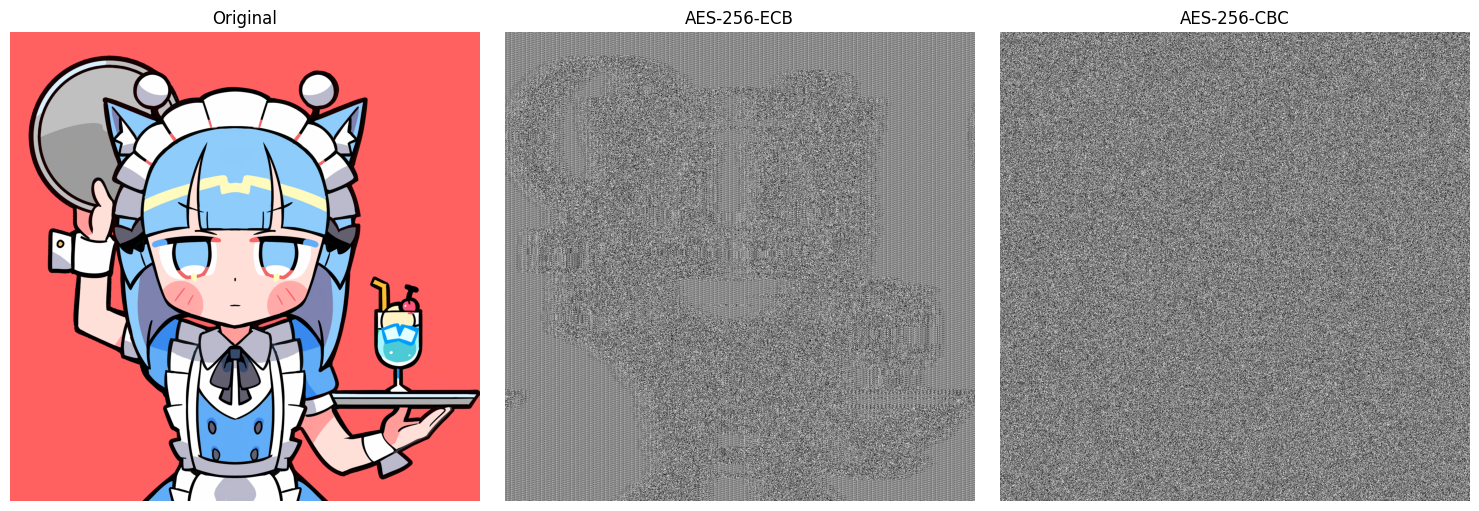

In [9]:
import io
import subprocess
from PIL import Image
import matplotlib.pyplot as plt

MAGICK = "/home/linuxbrew/.linuxbrew/bin/magick"
FILE = "AQUARA.png"

def run_command(command, input_data=None):
    result = subprocess.run(command, shell=True, capture_output=True, input=input_data)
    return io.BytesIO(result.stdout)

def convert_to_pbm(image_path, size="2000x2000"):
    command = f"{MAGICK} {image_path} -resize {size} pbm:-"
    return run_command(command)

def remove_pbm_header(pbm_file):
    pbm_data = pbm_file.read()
    return io.BytesIO(b'\n'.join(pbm_data.split(b'\n')[2:]))

def encrypt_image(input_file, algo, passwd=" "):
    command = f"openssl enc {algo} -in /dev/stdin -nosalt -pass pass:{passwd} -out /dev/stdout -pbkdf2"
    return run_command(command, input_file.read())

def add_pbm_header(encrypted_file):
    header = b"P4\n2000 2000\n"
    return io.BytesIO(header + encrypted_file.read())

def convert_pbm_to_png(pbm_file):
    pbm_image = Image.open(pbm_file)
    output = io.BytesIO()
    pbm_image.save(output, format='PNG')
    return output

def encode(image, algo):
    pbm_file = convert_to_pbm(image)
    raw_file = remove_pbm_header(pbm_file)
    encrypted_file = encrypt_image(raw_file, algo)
    png_output = convert_pbm_to_png(add_pbm_header(encrypted_file))
    
    return Image.open(io.BytesIO(png_output.getvalue()))  

def main():
    original_img = Image.open(FILE)
    ecb_img = encode(FILE, "-aes-256-ecb")
    cbc_img = encode(FILE, "-aes-256-cbc")
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original_img)
    axes[0].set_title("Original")
    axes[0].axis('off')  

    axes[1].imshow(ecb_img)
    axes[1].set_title("AES-256-ECB")
    axes[1].axis('off')

    axes[2].imshow(cbc_img)
    axes[2].set_title("AES-256-CBC")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
